In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import NNSingleFeatureModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
from time import time
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/{key}.pkl')
    return raw[key]

In [3]:
def load_sub_model_with_config(train_config, model_configs, sub_model_key, X_count=0, force_recreate=False):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    model_config = model_configs[sub_model_key]
    f = f"{path}/{prefix}{sub_model_key}.pth"
    if os.path.exists(f) and not force_recreate:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        mean_losses = checkpoint['mean_losses']
        next_epoch = checkpoint['next_epoch']
    else:
        raise Exception('Model does not exist')
    return net, loss_func, optimizer, mean_losses, next_epoch

def save_model_with_config(train_config, sub_model_key, **kwargs):
    path = train_config['model_path']
    prefix = train_config['model_prefix']
    f = f"{path}/{prefix}{sub_model_key}.pth"
    torch.save(kwargs, f)

In [4]:
def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    model.eval()
    X_tensor = torch.from_numpy(X.to_numpy()).float()
    nn_results = model(X_tensor).detach().numpy()
    return nn_results

In [5]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [6]:
train_config = {
    'dataset' : 'sample2_', # '', 'sample_', 'secret_'
    'model_prefix' : "TRY_2_", 
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t5_models",
    'device' : 'cpu',
}

In [7]:
%%time
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=train_config['dataset'],validation=True)).dropna()
ref_test, X_test, y_test = get_ref_X_y(test_df)
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']
y_test = y_test[y_cols]

Loading data to cache for: sample2_test
CPU times: user 1.79 s, sys: 2.73 s, total: 4.53 s
Wall time: 3.63 s


In [8]:
model_configs = {
    'y_INCLINATION': { 'feature_index': X_test.columns.get_loc('X_INCLINATION_1') },
    'y_ECCENTRICITY': { 'feature_index': X_test.columns.get_loc('X_ECCENTRICITY_1') },
    'y_MEAN_MOTION': { 'feature_index': X_test.columns.get_loc('X_MEAN_MOTION_1') },
    'y_RA_OF_ASC_NODE_REG': { 'feature_index': X_test.columns.get_loc('X_RA_OF_ASC_NODE_1') },
    'y_ARG_OF_PERICENTER_REG': { 'feature_index': X_test.columns.get_loc('X_ARG_OF_PERICENTER_1') },
    'y_REV_MA_REG': { 'feature_index': X_test.columns.get_loc('X_MEAN_ANOMALY_1') },
}

Loading existing model


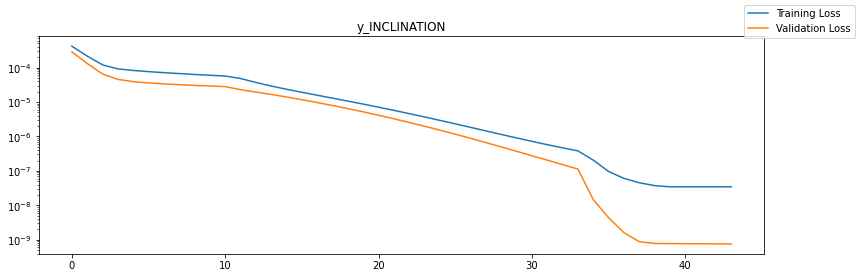

Epoch 44
    Test set MAE (L1) loss: 2.2017548313246555e-05
    Test set MSE (L2) loss: 1.1769277996810306e-09
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
Loading existing model


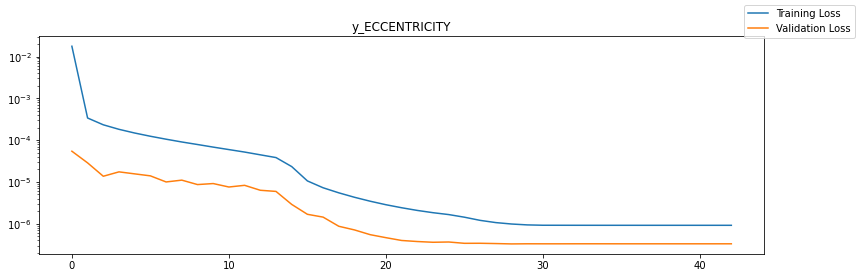

Epoch 43
    Test set MAE (L1) loss: 0.00038410252910943226
    Test set MSE (L2) loss: 1.00554625057954e-06
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):
Loading existing model
No data for y_MEAN_MOTION
Loading existing model
No data for y_RA_OF_ASC_NODE_REG
Loading existing model
No data for y_ARG_OF_PERICENTER_REG
Loading existing model


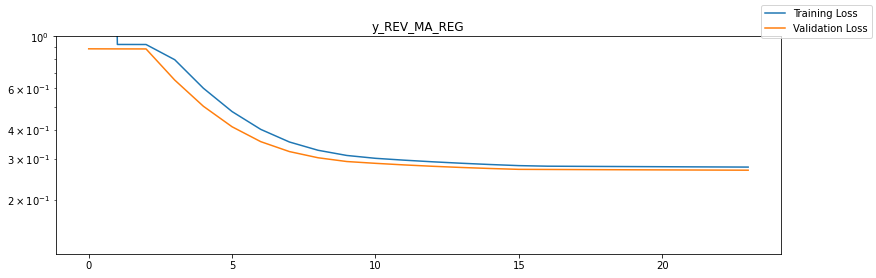

Epoch 24
    Test set MAE (L1) loss: 0.4275713122802847
    Test set MSE (L2) loss: 0.27643746471527775
Test - Ground Truth (normalized):
Test - Prediction (normalized):
Test - X (normalized):


,y_INCLINATION,y_INCLINATION,X_INCLINATION_1,y_ECCENTRICITY,y_ECCENTRICITY,X_ECCENTRICITY_1,y_REV_MA_REG,y_REV_MA_REG,X_MEAN_ANOMALY_1
494768,0.4602872222,0.4602943361,0.4602850000,0.0154940,0.0154783186,0.0155496,1.1631639105,1.0616774559,0.3495397222
588120,0.4611433333,0.4611580074,0.4611438889,0.0314404,0.0312413946,0.0313004,1.0066119475,1.2561732531,0.5440355556
750373,0.3944100000,0.3943945467,0.3944172222,0.0437932,0.0431457460,0.0432992,2.2095863981,1.5154230595,0.8032852778
738517,0.3944405556,0.3944599628,0.3944438889,0.0326392,0.0336719975,0.0337260,0.9959270741,1.3142845631,0.6021469444
668989,0.4620700000,0.4621082544,0.4620711111,0.0538332,0.0537892245,0.0537892,0.3028788827,0.9561821222,0.2440444444
...,...,...,...,...,...,...,...,...,...
611699,0.4611611111,0.4610998333,0.4611011111,0.0319196,0.0308494624,0.0309480,1.4743128272,1.3274027109,0.6152650000
1246914,0.5471944444,0.5472083092,0.5471972222,0.0125456,0.0122623798,0.0123292,1.1487396327,1.0390429497,0.3269052778
823890,0.4208416667,0.4208350778,0.4208427778,0.0491344,0.0503486097,0.0504636,1.7589057469,0.9487729669,0.2366352778
872796,0.5475350000,0.5475559235,0.5475516667,0.1754928,0.1756300628,0.1757144,1.3225012840,1.6769241095,0.9647863889


In [13]:
# Create or load all new sub models here if needed.
sample_idx = random.sample(list(X_test.index), 10000)
# sample_idx = X_test.index
all_models = {}
display_data = []
for sub_key in y_cols:
    # When new models are created, a dummy optimizer is used
    model, loss_func, optimizer, mean_losses, next_epoch = load_sub_model_with_config(train_config, model_configs, sub_key)
    all_models[sub_key] = (model, loss_func, optimizer, mean_losses, next_epoch)
    try:
        tl, vl = zip(*mean_losses)
    except:
        print(f"No data for {sub_key}")
        continue

    fig,ax = plt.subplots(figsize=(13,4))
    ax.plot(tl, label="Training Loss")
    ax.plot(vl, label="Validation Loss")
    ax.set_title(sub_key)
#     print(ax.get_ylim())
    ax.set_yscale('log')
    ax.set_ylim((ax.get_ylim()[0], min(1,ax.get_ylim()[1])))
    fig.legend()
    plt.show()
    
    trained_model = model
    X_sample = X_test.loc[sample_idx]
    y_sample = y_test.loc[sample_idx][[sub_key]]
    y_sample_pred = predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
    y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns, index=y_sample.index)  # put results into a dataframe
    print(f'Epoch {next_epoch}')
    print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
    print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')
    print("Test - Ground Truth (normalized):")
#     display(y_sample)
    print("Test - Prediction (normalized):")
#     display(y_sample_pred_df)
    print("Test - X (normalized):")
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
    display_data.append(y_sample)
    display_data.append(y_sample_pred_df)
    display_data.append(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1])
#     display(X_sample.iloc[:,model_configs[sub_key]['feature_index']:model_configs[sub_key]['feature_index']+1].values - y_sample_pred_df.values)
#     print(mean_losses[-5:])
    
df = pd.concat(display_data, axis=1)
display(df)

AdamW optimizer
Decrease learning rate slowly over time
Decrease weight decay if both training and validation are decreasing similarly